In [1]:
import os
import json
from PIL import Image
import numpy as np
import cv2 as cv
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.transforms.v2 as v2
from safetensors.torch import save_file, load_file
from tqdm import tqdm

In [2]:
# base paths
ROOT_DIR = os.path.join(os.getcwd(), os.pardir)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'unet_segmentation_train', 'road_marking')
IMG_DIR = os.path.join(TRAIN_DIR, 'img')
MASK_DIR = os.path.join(TRAIN_DIR, 'ann')
CHECKPOINT_PATH = os.path.join(ROOT_DIR, 'checkpoints', 'unet_segment_resnet50.safetensors')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARN_FROM_ZERO = False

In [3]:
class UNetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, height, width, transform=None, device='cpu'):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_filenames = []
        self.mask_filenames = []
        self.height = height
        self.width = width
        self.transform = transform

        # get img and mask annotation filenames 
        for filename in os.listdir(img_dir):
            img_path = os.path.join(img_dir, filename)
            mask_path = os.path.join(mask_dir, f'{filename}.json')            
            self.img_filenames.append(img_path)
            self.mask_filenames.append(mask_path)

    def __getitem__(self, idx):
        img = self.get_img(idx)
        mask = self.get_mask(idx)

        return img, mask

    def __len__(self):
        return len(self.img_filenames)
    
    def get_img(self, idx):
        """Loads image."""
        img = cv.imread(self.img_filenames[idx])
        img = cv.resize(img, (self.width, self.height), interpolation=cv.INTER_CUBIC)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # if self.transform:
        #     img = self.transform(img)

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])

        img = transform(img)

        return img.to(DEVICE)
    
    def get_mask(self, idx):
        """Loads mask and returns binary mask."""
        # get json mask
        with open(self.mask_filenames[idx], 'rb') as file:
            mask = json.load(file)
        
        mask = self.process_mask(mask)

        # fill binary mask
        binary_mask = np.zeros((1080, 1920), dtype=np.uint8)
        for polygone in mask:
            points = np.array(polygone, dtype=np.int32)
            cv.fillPoly(binary_mask, [points], color=1)

        binary_mask = cv.resize(binary_mask, (self.width, self.height), interpolation=cv.INTER_CUBIC)
        
        # if self.transform:
            # binary_mask = transforms.ToPILImage()(binary_mask)
            # binary_mask = self.transform(binary_mask)
            # binary_mask = transforms.ToTensor()(binary_mask)

        return torch.tensor(binary_mask, dtype=torch.float32).to(DEVICE)

    def process_mask(self, mask):
        """Gets polygones from mask dict."""
        objects = mask['objects']

        polygones = []
        for polygone in objects:
            points = polygone['points']['exterior']
            polygones.append(points)
        
        return polygones

In [4]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    # transforms.ColorJitter(brightness=)
])

train_dataset = UNetDataset(
    img_dir=IMG_DIR, 
    mask_dir=MASK_DIR, 
    height=736, 
    width=416,
    device=DEVICE
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    drop_last=True
)

In [5]:
if LEARN_FROM_ZERO:
    NUM_EPOCHS = 50
    torch.manual_seed(42)

    model = smp.Unet(
        encoder_name='resnet50',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1
    ).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        train_pbar = tqdm(iterable=train_dataloader, desc=f'Epoch {epoch}')
        for batch in train_pbar:
            img, mask = batch
            output = model(img).squeeze(1)
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_pbar.set_postfix({'loss': loss.item()})

    # model_state_dict = model.state_dict()
    # save_file(model_state_dict, CHECKPOINT_PATH)
    
else:
    state_dict = load_file(CHECKPOINT_PATH)
    model = smp.Unet(
        encoder_name='resnet50',
        in_channels=3,
        classes=1
    ).to(DEVICE)
    model.load_state_dict(state_dict)

In [6]:
img = cv.imread('../data/screenshots/607.jpg')
img = cv.resize(img, (736, 416), interpolation=cv.INTER_CUBIC)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = Image.fromarray(img)
img_cp = img.copy()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

img = transform(img)
img = img.to(DEVICE)

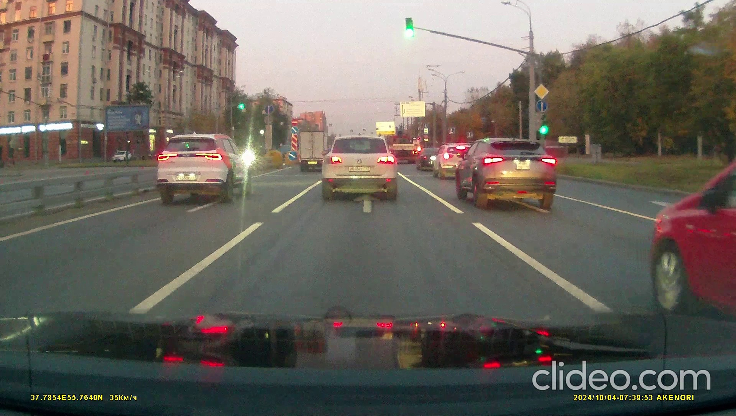

In [7]:
img_cp

In [8]:
model.eval()
predict = model(img.unsqueeze(0))
predict = predict.squeeze(0, 1)

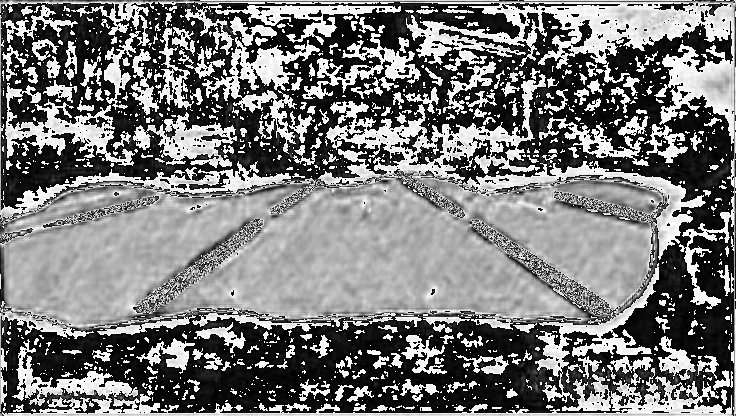

In [9]:
import torchvision.transforms as transforms
to_pil_transform = transforms.ToPILImage()
img = to_pil_transform(predict)
img